In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

 # xopt CNSGA2 function example
 
Experimental, using `pymoo` as a backend. 

In [2]:
from xopt.cmoo import cnsga2
import json
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

# Allows processes to work with macOS
from sys import platform
if platform == 'darwin':
    import multiprocessing as mp
    mp.set_start_method("fork")

In [3]:
NAME = 'TNK'
BOUND_LOW, BOUND_UP = [0.0, 0.0], [3.14159, 3.14159]  


X_RANGE = [0, 1.4]
Y_RANGE = [0, 1.4]

# Pure number version
def TNK(individual):    
    x1=individual[0]
    x2=individual[1]
    objectives =  (x1, x2)
    constraints = (x1**2+x2**2-1.0 - 0.1*np.cos(16*np.arctan2(x1, x2)), 0.5-(x1-0.5)**2-(x2-0.5)**2 )
    return objectives, constraints

# labeled version
def evaluate_TNK(inputs):
    
    info = {'some':'info', 'about':['the', 'run']}
    ind = [inputs['x1'], inputs['x2']]
    objectives, constraints = TNK(ind)    
    
    if 'sleeptime' in inputs:
        sleep(inputs['sleeptime'])
        x = np.random.random()
        if x < 0.3:
            sleep(inputs['sleeptime']*5)
    
    outputs = {'y1':objectives[0], 'y2':objectives[1], 'c1':constraints[0], 'c2':constraints[1]}
    
    return outputs

VOCS = {
    'name':'TNK_test',
    
    'variables': {
        'x1':[0, 3.14159],
        'x2':[0, 3.14159]
    },
    'objectives':{
        'y1':'MINIMIZE',
        'y2':'MINIMIZE'
        
    },
    'constraints':{
        'c1': ['GREATER_THAN', 0],
        'c2': ['GREATER_THAN', 0]
        
    },
    'constants':{'a':'dummy_constant'},
    'linked_variables':{'x9':'x1'}
    
    
}
TNK([0,0]), evaluate_TNK(dict(x1=1,x2=2, sleeptime=1))

(((0, 0), (-1.1, 0.0)), {'y1': 1, 'y2': 2, 'c1': 3.957802752, 'c2': -2.0})

In [4]:
# Pick a parallel method

from concurrent.futures import ProcessPoolExecutor as PoolExecutor
#from concurrent.futures import ThreadPoolExecutor as PoolExecutor
executor = PoolExecutor()
#executor=None

In [5]:
problem, res = cnsga2(executor, vocs=VOCS, evaluate_f=evaluate_TNK,
            max_generations = 20, population_size=64, output_path=None,
            rolling_evaluate=True,
            verbose=True) 

evaluating all at once (64, 2)


In [6]:
pop_data = res.pop

In [7]:
problem2, res2 = cnsga2(executor, vocs=VOCS, population=pop_data, evaluate_f=evaluate_TNK,
            max_generations = 40, population_size=64, output_path=None,
            rolling_evaluate=True,                                       
            verbose=True) 

evaluating all at once (64, 2)


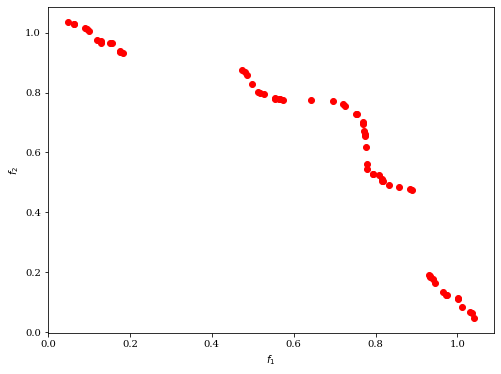

In [8]:
from pymoo.visualization.scatter import Scatter
plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(res2.F, color="red")
plot.show()

# Dask

In [9]:
from distributed import Client
client = Client()
client 

/Users/chrisonian/Code/miniconda3/envs/devel/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 58486 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: LocalCluster
Dashboard: http://127.0.0.1:58486/status,
Status: running,Using processes: True
Dashboard: http://127.0.0.1:58486/status,Workers: 4
Total threads: 8,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:58487,Workers: 4
Dashboard: http://127.0.0.1:58486/status,Total threads: 8
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:58499,Total threads: 2
Dashboard: http://127.0.0.1:58504/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:58492,


In [10]:
# Add sleep
VOCS['constants']['sleeptime'] = 1

In [11]:
%%time
# Non-rolling
problem3, res3 = cnsga2(client, vocs=VOCS, population=None, evaluate_f=evaluate_TNK,
            max_generations = 10, population_size=8, output_path=None,
            rolling_evaluate=False,                                       
            verbose=True) 

evaluating all at once (8, 2)
evaluating all at once (8, 2)
evaluating all at once (8, 2)
evaluating all at once (8, 2)
evaluating all at once (8, 2)
evaluating all at once (8, 2)
evaluating all at once (8, 2)
evaluating all at once (8, 2)
evaluating all at once (8, 2)
evaluating all at once (8, 2)
CPU times: user 2.59 s, sys: 595 ms, total: 3.18 s
Wall time: 1min 1s


In [12]:
%%time
# Rolling
problem3, res3 = cnsga2(client, vocs=VOCS, population=None, evaluate_f=evaluate_TNK,
            max_generations = 10, population_size=8, output_path=None,
            rolling_evaluate=True,                                       
            verbose=True) 

evaluating all at once (8, 2)
CPU times: user 20.6 s, sys: 345 ms, total: 20.9 s
Wall time: 26.8 s
